In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import glob as glob
import astropy.units as u
from scipy.interpolate import interp1d, CubicSpline
from scipy.integrate import simps
import matplotlib.pyplot as plt

In [2]:
def read_dat(filename):
    # read the .dat file
    data = pd.read_csv(filename, sep='\s+', header=None, skiprows=0)
    # y is fluxdensity in wavelength, x is wavelength
    data.columns = ['x', 'y']
    return data

def read_data_file(file):
    
    with open(file, 'r') as f:
        lines = f.readlines()
    data = []
    
    for line in lines:
        if line[0] != '#':
            data.append([float(x) for x in line.split()])
    # make data a pd.DataFrame
    data = pd.DataFrame(data)
    data.columns = ['x', 'y']
    return data

def resample(model, _filter, norm=False):
    
    """ Resample model to the filter wavelength 
    
    Returns:
    --------
    _filter['x'] : array-like
        The filter x values
    
    y : array-like
        The resampled model y values
    
    Parameters:
    -----------
    model : dict
        The model data
    _filter : dict
        The filter data
    """
    
    # interpolate model to the filter wavelength
    f = interp1d(model['x'], model['y'], kind='linear', fill_value="extrapolate")
    y = f(_filter['x'])
    
    if norm:
        # calculate the integral of the filter
        integral = simps(_filter['y'], _filter['x'])
        
        # calculate the integral of the model
        integral_model = simps(y, _filter['x'])
        
        # normalize the model
        y = y * integral / integral_model
    
    return _filter['x'], y

def flumbda2fnu(wl, flu):
    
    flu = flu * u.erg / u.s / u.AA / u.cm**2
    fnu = flu.to(u.erg / u.s / u.Hz / u.cm**2,
            equivalencies=u.spectral_density(wl * u.AA))
    
    return fnu.value

def fnu2flumbda(wl, fnu):
    
    fnu = fnu * u.erg / u.s / u.Hz / u.cm**2
    flu = fnu.to(u.erg / u.s / u.AA / u.cm**2,
            equivalencies=u.spectral_density(wl * u.AA))
    
    return flu.value

def observed_mag(flu, wavelength, _filter):
    
    """ Calculate the observed magnitude of the model
    
    Returns:
    --------
    mag : float
        The observed magnitude of the model flux passed through the filter
        
    Parameters:
    -----------
    flu : array-like
        The model flux
        
    wavelength : array-like
        The wavelength of the model flux
        
    _filter : dict
        The filter data
    
    """
    
    nu = 3e18 / wavelength
    fnu = flumbda2fnu(np.array(wavelength), flu)
    
    mag = -2.5 * np.log10(
        simps(fnu*_filter['y'], nu) / simps(3631*_filter['y'], nu)
    )
    
    return mag

def plot_Fmodel_cc(data, Nfilter, plot=False):
    
    """ Plot the model flux on the color color plot
    
    Returns:
    --------
    Temperature : array-like
        The temperature of the model
        
    F115W : array-like
        The F115W magnitude of the model
        
    F277W : array-like
        The F277W magnitude of the model
        
    F444W : array-like
        The F444W magnitude of the model
        
    Parameters:
    ----------
    data : array-like
        The model data
        
    _filter : array-like
        The filter data
        
    plot : bool
        If True, plot the color-color plot
    """
    
    Temperature = []
    F115W = []
    F277W = []
    F444W = []
    
    for i in range(len(data)):
        
        model = read_dat(data[i])
        
        if (float(data[i].split('/')[-1].split('t')[1].split('g')[0]) < 1310) & (float(data[i].split('/')[-1].split('t')[1].split('g')[0]) > 470):
        
            _filter = read_data_file(Nfilter[0])
            x, y = resample(model, _filter)
            F115W.append(observed_mag(y, x, _filter))
            
            _filter = read_data_file(Nfilter[2])
            x, y = resample(model, _filter)
            F277W.append(observed_mag(y, x, _filter))
            
            _filter = read_data_file(Nfilter[3])
            x, y = resample(model, _filter)
            F444W.append(observed_mag(y, x, _filter))
            
            Temperature.append(
                float(data[i].split('/')[-1].split('t')[1].split('g')[0])
            )
            
        else:
            pass
        
    F115W = np.array(F115W)
    F277W = np.array(F277W)
    F444W = np.array(F444W)
    Temperature = np.array(Temperature)
        
    if plot:
        plt.figure(figsize=(10, 10))
        
        # plot the model flux on the color-color plot and use T as colorbar
        # Turn Temperature into color map
        
        
        plt.scatter(F277W-F444W, F115W-F277W, c=Temperature, cmap='viridis', label='Model')
        
        plt.colorbar(label='Temperature')
        
        
        plt.plot([1.1, 1.1], [-4, -0.8], color='black', lw=1, alpha=0.5)
        plt.plot([1.1, 5], [-0.8, -0.8], color='black', lw=1, alpha=0.5)
        
        plt.xlabel('F115W-F277W')
        plt.ylabel('F277W-F444W')
        plt.title('Color-Color Plot')
        plt.legend()
        plt.show()
    else:
        return Temperature, F115W, F277W, F444W

def ccplot(data, candi, magtype="AUTO", save=False):
    
    m444 = data[f'MAG_{magtype}_F444W']
    m277 = data[f'MAG_{magtype}_F277W']
    # m150 = data[f'MAG_{magtype}_F150W']
    m115 = data[f'MAG_{magtype}_F115W']
    
    # m444c = candi[f'MAG_{magtype}_F444W']
    # m277c = candi[f'MAG_{magtype}_F277W']
    # m150 = candi[f'MAG_{magtype}_F150W']
    # m115c = candi[f'MAG_{magtype}_F115W']
    
    selected = data.loc[(m277-m444>1.1)&(m115-m277<-0.8)]
    
    detcted = selected.loc[(selected[f'MAGERR_{magtype}_F444W']>0)&(selected[f'MAGERR_{magtype}_F277W']>0)&(selected[f'MAGERR_{magtype}_F115W']>0)]
    nondetect = selected.loc[(selected[f'MAGERR_{magtype}_F444W']<0)|(selected[f'MAGERR_{magtype}_F277W']<0)|(selected[f'MAGERR_{magtype}_F115W']<0)]

    fig, ax = plt.subplots(figsize=(7, 5), dpi=200)

    # plt.scatter(m277-m444, m115-m277, 
    #             s=2, label='COSMOS-Webb sources', color='#AAAAAA', alpha=0.5)
    
    hb = ax.hexbin(
        m277-m444, m115-m277,
        gridsize=1000, cmap='Greys', bins='log'
    )
    
    ax.errorbar(detcted[f'MAG_{magtype}_F277W']-detcted[f'MAG_{magtype}_F444W'], detcted[f'MAG_{magtype}_F115W']-detcted[f'MAG_{magtype}_F277W'], 
                np.sqrt(detcted[f'MAGERR_{magtype}_F277W']**2+detcted[f'MAGERR_{magtype}_F444W']**2), 
                np.sqrt(detcted[f'MAGERR_{magtype}_F115W']**2+detcted[f'MAGERR_{magtype}_F277W']**2),
            color='red', ls='', lw=1, fmt='.', label='Sources pass color criteria')
    # ax.plot([1.1, 1.1], [-4, -0.8], color='black', lw=1, alpha=0.5)
    # ax.plot([1.1, 5], [-0.8, -0.8], color='black', lw=1, alpha=0.5)
    sc1 = ax.scatter(low_m[2]-low_m[3], low_m[1]-low_m[2], c=low_m[0], s=8,
                marker='v', cmap='viridis', label='0.5 Solar metallicity BD Model')
    sc2 = ax.scatter(nor_m[2]-nor_m[3], nor_m[1]-nor_m[2], c=nor_m[0], s=8,
                marker='o', cmap='viridis', label='1.0 Solar metallicity BD Model')
    sc3 = ax.scatter(high_m[2]-high_m[3], high_m[1]-high_m[2], c=high_m[0], s=8,
                marker='^', cmap='viridis', label='1.5 Solar metallicity BD Model')
    
    # ax.plot(low_m[2]-low_m[3], low_m[1]-low_m[2], c='k')
    # ax.plot(nor_m[2]-nor_m[3], nor_m[1]-nor_m[2], c='k')
    # ax.plot(high_m[2]-high_m[3], high_m[1]-high_m[2], c='k')
    
    cbar = fig.colorbar(sc3, ax=ax)
    cbar.ax.tick_params(labelsize=18)  # Change colorbar tick label fontsize
    cbar.set_label(label='Sonora-Bobcat T$_{eff}$ [K]' , fontsize=20)  # Change colorbar label fontsize
    
    ax.plot([1.1, 1.1], [-4, -0.8], color='#555555', lw=2, alpha=1,
            label='Selection criteria from Wang et al.', zorder=1)
    ax.plot([1.1, 15], [-0.8, -0.8], color='#555555', lw=2, alpha=1, zorder=1)
    
    # ax.scatter(m277c-m444c, m115c-m277c, 
    #             marker='*', s=25, label='BD candidates', color='black', alpha=0.9, zorder=10)
    
        # Adding arrows for non-detected candidates
    nondetect_115 = nondetect.loc[nondetect[f'MAGERR_{magtype}_F115W'] < 0]
    nondetect_277 = nondetect.loc[nondetect[f'MAGERR_{magtype}_F277W'] < 0]
    nondetect_444 = nondetect.loc[nondetect[f'MAGERR_{magtype}_F444W'] < 0]
    
    # print(len(nondetect_115), len(nondetect_277), len(nondetect_444))

    for idx, row in nondetect_115.iterrows():
        ax.arrow(row[f'MAG_{magtype}_F277W'] - row[f'MAG_{magtype}_F444W'], row[f'MAG_{magtype}_F115W'] - row[f'MAG_{magtype}_F277W'],
                0, 0.5, head_width=0.05, head_length=0.1, fc='orange', ec='orange')

    for idx, row in nondetect_277.iterrows():
        ax.arrow(row[f'MAG_{magtype}_F277W'] - row[f'MAG_{magtype}_F444W'], row[f'MAG_{magtype}_F115W'] - row[f'MAG_{magtype}_F277W'],
                0.2, 0, head_width=0.05, head_length=0.1, fc='orange', ec='orange')

    for idx, row in nondetect_444.iterrows():
        ax.arrow(row[f'MAG_{magtype}_F277W'] - row[f'MAG_{magtype}_F444W'], row[f'MAG_{magtype}_F115W'] - row[f'MAG_{magtype}_F277W'],
                1, 0, head_width=0.05, head_length=0.1, fc='orange', ec='orange')

    
    ax.set_xlim(-2, 6)
    ax.set_ylim(-3, 4)
    
    ax.set_xlabel('F277W - F444W [mag]', fontsize=20)
    ax.set_ylabel('F115W - F277W [mag]', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    # larger fontsize for colorbar
    
    cbar.ax.tick_params(labelsize=15)
    
    # plt.title(f'Color-color plot of all sources')
    
    ax.legend(loc='upper right', fontsize=12)
    
    plt.tight_layout()
    
    if save:
        plt.savefig('/home/yuan/JWST/louvre/bd_ccmodelflux.png', format='png', dpi=200)
    
    plt.show()
    
    return selected

def cc_para(data, candi, para, th1, th2, magtype="AUTO"):
    
    m444 = data[f'MAG_{magtype}_F444W'].loc[data[para] < th2]
    m277 = data[f'MAG_{magtype}_F277W'].loc[data[para] < th2]
    m115 = data[f'MAG_{magtype}_F115W'].loc[data[para] < th2]
    
    m444b = data[f'MAG_{magtype}_F444W'].loc[data[para] > th1]
    m277b = data[f'MAG_{magtype}_F277W'].loc[data[para] > th1]
    m115b = data[f'MAG_{magtype}_F115W'].loc[data[para] > th1]
    
    m444c = candi[f'MAG_{magtype}_F444W']
    m277c = candi[f'MAG_{magtype}_F277W']
    m115c = candi[f'MAG_{magtype}_F115W']
    
    # print(m115c)

    # selected = data.loc[(m277-m444+data.MAGERR_BEST_277+data.MAGERR_BEST_444>1.1)&(m115-m277-data.MAGERR_BEST_115+data.MAGERR_BEST_277<-0.8)]
    # selected = data.loc[(m277-m444>1.1)&(m115-m277<-0.8)]

    plt.figure(figsize=(10, 7), dpi=200)

    # plt.scatter(m277-m444, m115-m277, 
    #             s=2, label='COSMOS-Webb sources', color='#AAAAAA', alpha=0.5)
    
    plt.scatter(m277-m444, m115-m277, 
                s=3, label=f'elongation<{th2}', color='black', alpha=0.5)
    
    plt.scatter(m277b-m444b, m115b-m277b, 
                s=3, label=f'elongation>{th1}', color='#00CCDD', alpha=0.5)
    
    # plt.errorbar(selected[f'MAG_{magtype}_F277W']-selected[f'MAG_{magtype}_F444W'], selected[f'MAG_{magtype}_F115W']-selected[f'MAG_{magtype}_F277W'], 
    #             np.sqrt(selected[f'MAGERR_{magtype}_F277W']**2+selected[f'MAGERR_{magtype}_F444W']**2), 
    #             np.sqrt(selected[f'MAGERR_{magtype}_F115W']**2+selected[f'MAGERR_{magtype}_F277W']**2),
    #         color='red', ls='', lw=1, fmt='.', label=f'{len(selected)} candidates pass color criteria')
    # plt.plot([1.1, 1.1], [-4, -0.8], color='black', lw=1, alpha=0.5)
    # plt.plot([1.1, 5], [-0.8, -0.8], color='black', lw=1, alpha=0.5)
    # plt.scatter(low_m[2]-low_m[3], low_m[1]-low_m[2], c=low_m[0], s=8,
    #             marker='v', cmap='viridis', label='0.5 Solar metallicity BD Model')
    # plt.scatter(nor_m[2]-nor_m[3], nor_m[1]-nor_m[2], c=nor_m[0], s=8,
    #             marker='o', cmap='viridis', label='1.0 Solar metallicity BD Model')
    # plt.scatter(high_m[2]-high_m[3], high_m[1]-high_m[2], c=high_m[0], s=8,
    #             marker='^', cmap='viridis', label='1.5 Solar metallicity BD Model')
    # plt.colorbar(label='Temperature')
    
    plt.plot([1.1, 1.1], [-4, -0.8], color='#555555', lw=2, alpha=1,
            label='Selection criteria from Wang et. al', zorder=1)
    plt.plot([1.1, 15], [-0.8, -0.8], color='#555555', lw=2, alpha=1, zorder=1)
    
    plt.scatter(m277c-m444c, m115c-m277c, 
                marker='*', s=25, label='Final candidates', color='black', alpha=0.9, zorder=10)

    
    plt.xlim(-2, 6)
    plt.ylim(-4, 4)
    
    plt.xlabel('F277W - F444W [mag]')
    plt.ylabel('F115W - F277W [mag]')
    # plt.title(f'Color-color plot of all sources')
    
    plt.legend(loc='upper right')
    
    plt.show()
    
def read_model(data_file):
    # read in the data
    
    spec = [] # star sed, [float, float]
    MODname = [] # model name list, string
    Ldir = '/home/yuan/LePhare/lephare_dev/sed/STAR/'
    
    with open(Ldir+'STAR_MOD_ALL2.list', 'r') as f:
        lines = f.readlines()
    for line in lines:
        MODname.append(line.split('\t')[0].split('/')[-1][:-5])
    
    with open(data_file, 'r') as f2:
        data = f2.readlines()
        model_name = MODname[int(data[12].split()[2])-1]
        
        # fitted flux
        startline = int(data[5].split()[1])+int(data[7].split()[1])+int(data[11].split()[1])+23
        # print(startline)
        for j in range(startline, len(data)):
            spec.append([float(data[j].split()[0]), float(data[j].split()[1])])
        spec = np.array(spec)
        
        mag2uJy = lambda x: 10**((23.9-x)/2.5)
        spec[:,1] = mag2uJy(spec[:,1])
        
        spec_data = pd.DataFrame(spec)
        spec_data.columns = ['x', 'y']
        
    # model flux
    with open(Ldir+'Sonora_Bobcat/spec_ds/'+model_name+'.dat', 'r') as f:
        data = f.readlines()
        model = []
        for j in range(1, len(data)):
            model.append([float(data[j].split()[0]), float(data[j].split()[1])])
        model = np.array(model)
        # print(model[:,0])
    
    return model_name, spec_data, model

In [33]:
def flumbda2fnu(wl, flu):
    
    flu = flu * u.erg / u.s / u.AA / u.cm**2
    fnu = flu.to(u.erg / u.s / u.Hz / u.cm**2,
            equivalencies=u.spectral_density(wl * u.AA))
    
    return fnu.value

def fnu2flumbda(wl, fnu):
    
    fnu = fnu * u.erg / u.s / u.Hz / u.cm**2
    flu = fnu.to(u.erg / u.s / u.AA / u.cm**2,
            equivalencies=u.spectral_density(wl * u.AA))
    
    return flu.value

def read_data_file(file):
    
    with open(file, 'r') as f:
        lines = f.readlines()
    data = []
    
    for line in lines:
        if line[0] != '#':
            data.append([float(x) for x in line.split()])
    # make data a pd.DataFrame
    data = pd.DataFrame(data)
    data.columns = ['x', 'y']
    return data

def read_filter_file(_filter):
    
    ''' read in the filter data
    Returns:
    --------
    data : pandas.DataFrame [x, y] = [frequency (Hz), transmission]
        The filter data
    
    parameters:
    -----------
    _filter : string
        dircetory of the filter file
    '''
    
    # dir = '/home/yuan/LePhare/lephare_dev/filt/jwst/'
    
    # data = read_data_file(dir+_filter.lower()+'.pb')
    data = read_data_file(_filter)
    
    x = np.array(data['x'])
    x = x*u.AA
    x = x.to(u.Hz, equivalencies=u.spectral())
    
    data['x'] = x.value
    
    return data

def read_LePhare_result(data_file):
    
    ''' read in the LePhare result file and return the model name and fitted flux
    Returns:
    --------
    model_name : string
        The name of the model
        
    spec_data : pandas.DataFrame [x, y] = [frequency (Hz), flux (uJy)]
        The fitted flux data
        
    Parameters:
    -----------
    data_file : string
        The path of the LePhare result file
    '''
    
    # read in the data
    
    spec = [] # star sed, [float, float]
    MODname = [] # model name list, string
    Ldir = '/home/yuan/LePhare/lephare_dev/sed/STAR/'
    
    with open(Ldir+'STAR_MOD_ALL2.list', 'r') as f:
        lines = f.readlines()
    for line in lines:
        MODname.append(line.split('\t')[0].split('/')[-1][:-5])
    
    with open(data_file, 'r') as f2:
        data = f2.readlines()
        model_name = MODname[int(data[12].split()[2])-1]
        
        # fitted flux
        startline = int(data[5].split()[1])+int(data[7].split()[1])+int(data[11].split()[1])+23
        # print(startline)
        for j in range(startline, len(data)):
            spec.append([float(data[j].split()[0]), float(data[j].split()[1])])
        spec = np.array(spec)
        
        # result file output unit is mag, convert to uJy
        mag2uJy = lambda x: 10**((23.9-x)/2.5)
        spec[:,1] = mag2uJy(spec[:,1])
        
        # result file output unit is wavelength, convert to frequency
        spec[:,0] = (spec[:,0] * u.AA).to(u.Hz, equivalencies=u.spectral()).value
        
        spec_data = pd.DataFrame(spec)
        spec_data.columns = ['x', 'y']
    
    return model_name, spec_data

def read_model(data_file):
    
    ''' read in the model data
    Returns:
    --------
    model_data : pandas.DataFrame [x, y] = [frequency (Hz), flux (uJy)] 
    
    parameters:
    -----------
    data_file : string
        The path of the model data file
    '''
    
    # model flux
    with open(data_file, 'r') as f:
        data = f.readlines()
        wl = []
        flambda = []
        for j in range(1, len(data)):
            wl.append(float(data[j].split()[0]))
            flambda.append(float(data[j].split()[1]))
    
    flambda = flumbda2fnu(wl, flambda)*10**6 # Jy convert to uJy
    wl = (wl * u.AA).to(u.Hz, equivalencies=u.spectral()).value
    model_data = pd.DataFrame([wl, flambda]).T
    model_data.columns = ['x', 'y']
    
    return model_data

def read_flux_table(flux_table):
    
    file = flux_tables[0]
    with open(file, 'r') as f:
        lines = f.readlines()
        
    data = []
    header = lines[6].split()
    for i in range(len(lines)-8):
        data.append([float(x) for x in lines[i+8].split()])
    
    data = pd.DataFrame(data, columns=header)
        
    return data

def resample(frequency, fnu, _filter, norm=False):
    
    """ Resample model to the filter x grid 
    
    Returns:
    --------
    filter_data['x'] : np.array
        The filter x grid
    
    interpolated_fnu : np.array
        The resampled model fnu values
    
    Parameters:
    -----------
    frequency : array-like
        The frequency of the model flux
        
    fnu : array-like
        The model flux
        
    _filter : string
        The filter name
    """
    
    filter_data = read_filter_file(_filter)
    
    # interpolate model to the filter x grid
    f = interp1d(frequency, fnu, kind='linear', fill_value="extrapolate")
    interpolated_fnu = f(filter_data['x'])
    
    if norm:
        # calculate the integral of the filter
        integral = simps(filter_data['y'], filter_data['x'])
        
        # calculate the integral of the model
        integral_model = simps(interpolated_fnu, filter_data['x'])
        
        # normalize the model
        interpolated_fnu = interpolated_fnu * integral / integral_model
    
    return np.array(filter_data['x']), np.array(interpolated_fnu)

def observed_flux(frequency, fnu, _filter, output='uJy'):
    
    """ Calculate the observed flux of the model
    
    Returns:
    --------
    mag : float
        The observed magnitude of the model flux passed through the filter
        
    Parameters:
    -----------
    frequency : array-like
        The frequency of the model flux
        
    fnu : array-like
        The model flux
        
    _filter : string
        The filter name
    
    output : string
        The output unit, 'mag' or 'uJy'
            mag: return the magnitude
            uJy: return log \int fnu(uJy)*filter dnu
    """
    
    model_data = resample(frequency, fnu, _filter)
    filter_data = read_filter_file(_filter)
    
    # zero point
    zp = 3631*10**6 # uJy
    Izp = -simps(zp*filter_data['y'], filter_data['x'])
    # calculate the total flux
    total_flux = -simps(model_data[1]*filter_data['y'], model_data[0])
    # print(total_flux, Izp)
    
    mag = -2.5*np.log10(total_flux/Izp)
    
    if output == 'mag':
        return mag
    
    if output == 'uJy':
        return (23.9-mag)*0.4

def plot_Fmodel_cc(data, Nfilter, plot=False):
    
    """ Plot the model flux on the color color plot
    
    Returns:
    --------
    Temperature : array-like
        The temperature of the model
        
    F115W : array-like
        The F115W magnitude of the model
        
    F277W : array-like
        The F277W magnitude of the model
        
    F444W : array-like
        The F444W magnitude of the model
        
    Parameters:
    ----------
    data : array-like
        The model data
        
    _filter : array-like
        The filter data
        
    plot : bool
        If True, plot the color-color plot
    """
    
    Temperature = []
    F115W = []
    F277W = []
    F444W = []
    
    for i in range(len(data)):
        
        if (float(data[i].split('/')[-1].split('t')[1].split('g')[0]) < 1310) & (float(data[i].split('/')[-1].split('t')[1].split('g')[0]) > 470):
            
            model_data = read_model(data[i])
            F115W.append(observed_flux(model_data['x'], model_data['y'], Nfilter[0], output='mag'))
            F277W.append(observed_flux(model_data['x'], model_data['y'], Nfilter[2], output='mag'))
            F444W.append(observed_flux(model_data['x'], model_data['y'], Nfilter[3], output='mag'))
            
            Temperature.append(
                float(data[i].split('/')[-1].split('t')[1].split('g')[0])
            )
            
        else:
            pass
        
    F115W = np.array(F115W)
    F277W = np.array(F277W)
    F444W = np.array(F444W)
    Temperature = np.array(Temperature)
        
    if plot:
        plt.figure(figsize=(10, 10))
        
        # plot the model flux on the color-color plot and use T as colorbar
        # Turn Temperature into color map
        
        
        plt.scatter(F277W-F444W, F115W-F277W, c=Temperature, cmap='viridis', label='Model')
        
        plt.colorbar(label='Temperature')
        
        
        plt.plot([1.1, 1.1], [-4, -0.8], color='black', lw=1, alpha=0.5)
        plt.plot([1.1, 5], [-0.8, -0.8], color='black', lw=1, alpha=0.5)
        
        plt.xlabel('F115W-F277W')
        plt.ylabel('F277W-F444W')
        plt.title('Color-Color Plot')
        plt.legend()
        plt.show()
    else:
        return Temperature, F115W, F277W, F444W

def ccplot(data, candi, magtype="AUTO", save=False):
    
    m444 = data[f'MAG_{magtype}_F444W']
    m277 = data[f'MAG_{magtype}_F277W']
    # m150 = data[f'MAG_{magtype}_F150W']
    m115 = data[f'MAG_{magtype}_F115W']
    
    # m444c = candi[f'MAG_{magtype}_F444W']
    # m277c = candi[f'MAG_{magtype}_F277W']
    # m150 = candi[f'MAG_{magtype}_F150W']
    # m115c = candi[f'MAG_{magtype}_F115W']
    
    selected = data.loc[(m277-m444>1.1)&(m115-m277<-0.8)]
    
    detcted = selected.loc[(selected[f'MAGERR_{magtype}_F444W']>0)&(selected[f'MAGERR_{magtype}_F277W']>0)&(selected[f'MAGERR_{magtype}_F115W']>0)]
    nondetect = selected.loc[(selected[f'MAGERR_{magtype}_F444W']<0)|(selected[f'MAGERR_{magtype}_F277W']<0)|(selected[f'MAGERR_{magtype}_F115W']<0)]

    fig, ax = plt.subplots(figsize=(7, 5), dpi=200)

    # plt.scatter(m277-m444, m115-m277, 
    #             s=2, label='COSMOS-Webb sources', color='#AAAAAA', alpha=0.5)
    
    hb = ax.hexbin(
        m277-m444, m115-m277,
        gridsize=1000, cmap='Greys', bins='log'
    )
    
    ax.errorbar(detcted[f'MAG_{magtype}_F277W']-detcted[f'MAG_{magtype}_F444W'], detcted[f'MAG_{magtype}_F115W']-detcted[f'MAG_{magtype}_F277W'], 
                np.sqrt(detcted[f'MAGERR_{magtype}_F277W']**2+detcted[f'MAGERR_{magtype}_F444W']**2), 
                np.sqrt(detcted[f'MAGERR_{magtype}_F115W']**2+detcted[f'MAGERR_{magtype}_F277W']**2),
            color='red', ls='', lw=2, fmt='.')
    ax.scatter(
        detcted[f'MAG_{magtype}_F277W']-detcted[f'MAG_{magtype}_F444W'], detcted[f'MAG_{magtype}_F115W']-detcted[f'MAG_{magtype}_F277W'],
        color='red', edgecolors='k', marker='o', s=45, label='Sources pass \ncolor criteria', zorder=11
    )
    # ax.plot([1.1, 1.1], [-4, -0.8], color='black', lw=1, alpha=0.5)
    # ax.plot([1.1, 5], [-0.8, -0.8], color='black', lw=1, alpha=0.5)
    sc1 = ax.scatter(low_m[2]-low_m[3], low_m[1]-low_m[2], c=low_m[0], s=8,
                marker='v', cmap='viridis', label='0.5 Z$_{\odot}$ BD Model')
    sc2 = ax.scatter(nor_m[2]-nor_m[3], nor_m[1]-nor_m[2], c=nor_m[0], s=8,
                marker='o', cmap='viridis', label='1.0 Z$_{\odot}$ BD Model')
    sc3 = ax.scatter(high_m[2]-high_m[3], high_m[1]-high_m[2], c=high_m[0], s=8,
                marker='^', cmap='viridis', label='1.5 Z$_{\odot}$ BD Model')
    
    # ax.plot(low_m[2]-low_m[3], low_m[1]-low_m[2], c='k')
    # ax.plot(nor_m[2]-nor_m[3], nor_m[1]-nor_m[2], c='k')
    # ax.plot(high_m[2]-high_m[3], high_m[1]-high_m[2], c='k')
    
    cbar = fig.colorbar(sc3, ax=ax)
    cbar.ax.tick_params(labelsize=18)  # Change colorbar tick label fontsize
    cbar.set_label(label='Sonora-Bobcat T$_{eff}$ [K]' , fontsize=20)  # Change colorbar label fontsize
    
    ax.plot([1.1, 1.1], [-4, -0.8], color='#555555', lw=2, alpha=1,
            label='Selection criteria \nfrom Wang et al 2023.', zorder=1)
    ax.plot([1.1, 15], [-0.8, -0.8], color='#555555', lw=2, alpha=1, zorder=1)
    
    # ax.scatter(m277c-m444c, m115c-m277c, 
    #             marker='*', s=25, label='BD candidates', color='black', alpha=0.9, zorder=10)
    
        # Adding arrows for non-detected candidates
    nondetect_115 = nondetect.loc[nondetect[f'MAGERR_{magtype}_F115W'] < 0]
    nondetect_277 = nondetect.loc[nondetect[f'MAGERR_{magtype}_F277W'] < 0]
    nondetect_444 = nondetect.loc[nondetect[f'MAGERR_{magtype}_F444W'] < 0]
    
    # print(len(nondetect_115), len(nondetect_277), len(nondetect_444))

    for idx, row in nondetect_115.iterrows():
        ax.arrow(row[f'MAG_{magtype}_F277W'] - row[f'MAG_{magtype}_F444W'], row[f'MAG_{magtype}_F115W'] - row[f'MAG_{magtype}_F277W'],
                0, 0.3, width=0.05, head_width=0.15, head_length=0.1, fc='orange', ec='orange')

    for idx, row in nondetect_277.iterrows():
        ax.arrow(row[f'MAG_{magtype}_F277W'] - row[f'MAG_{magtype}_F444W'], row[f'MAG_{magtype}_F115W'] - row[f'MAG_{magtype}_F277W'],
                0.2, 0, width=0.05, head_width=0.15, head_length=0.1, fc='orange', ec='orange')

    for idx, row in nondetect_444.iterrows():
        ax.arrow(row[f'MAG_{magtype}_F277W'] - row[f'MAG_{magtype}_F444W'], row[f'MAG_{magtype}_F115W'] - row[f'MAG_{magtype}_F277W'],
                1, 0, width=0.05, head_width=0.15, head_length=0.1, fc='orange', ec='orange')

    
    ax.set_xlim(-1, 5)
    ax.set_ylim(-3, 3)
    
    ax.set_xlabel('F277W - F444W [mag]', fontsize=20)
    ax.set_ylabel('F115W - F277W [mag]', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    # larger fontsize for colorbar
    
    cbar.ax.tick_params(labelsize=15)
    
    # plt.title(f'Color-color plot of all sources')
    
    ax.legend(loc='upper right', fontsize=11)
    
    plt.tight_layout()
    
    if save:
        plt.savefig('/home/yuan/JWST/louvre/bd_ccmodelflux.png', format='png', dpi=200)
    
    plt.show()
    
    return selected


### Model and filters

In [4]:
filter_name = sorted(glob.glob('/home/yuan/LePhare/lephare_dev/filt/jwst/*'))
filter_name.append('/home/yuan/LePhare/lephare_dev/filt/hst/F814W.pb')
# data_name = sorted(glob.glob('STAR/Sonora_Bobcat/spec_ds/*g*nc_m0.dat'))
data_files = sorted(glob.glob('/home/yuan/LePhare/lephare_dev/bd_fit/BD_24/*.spec'))

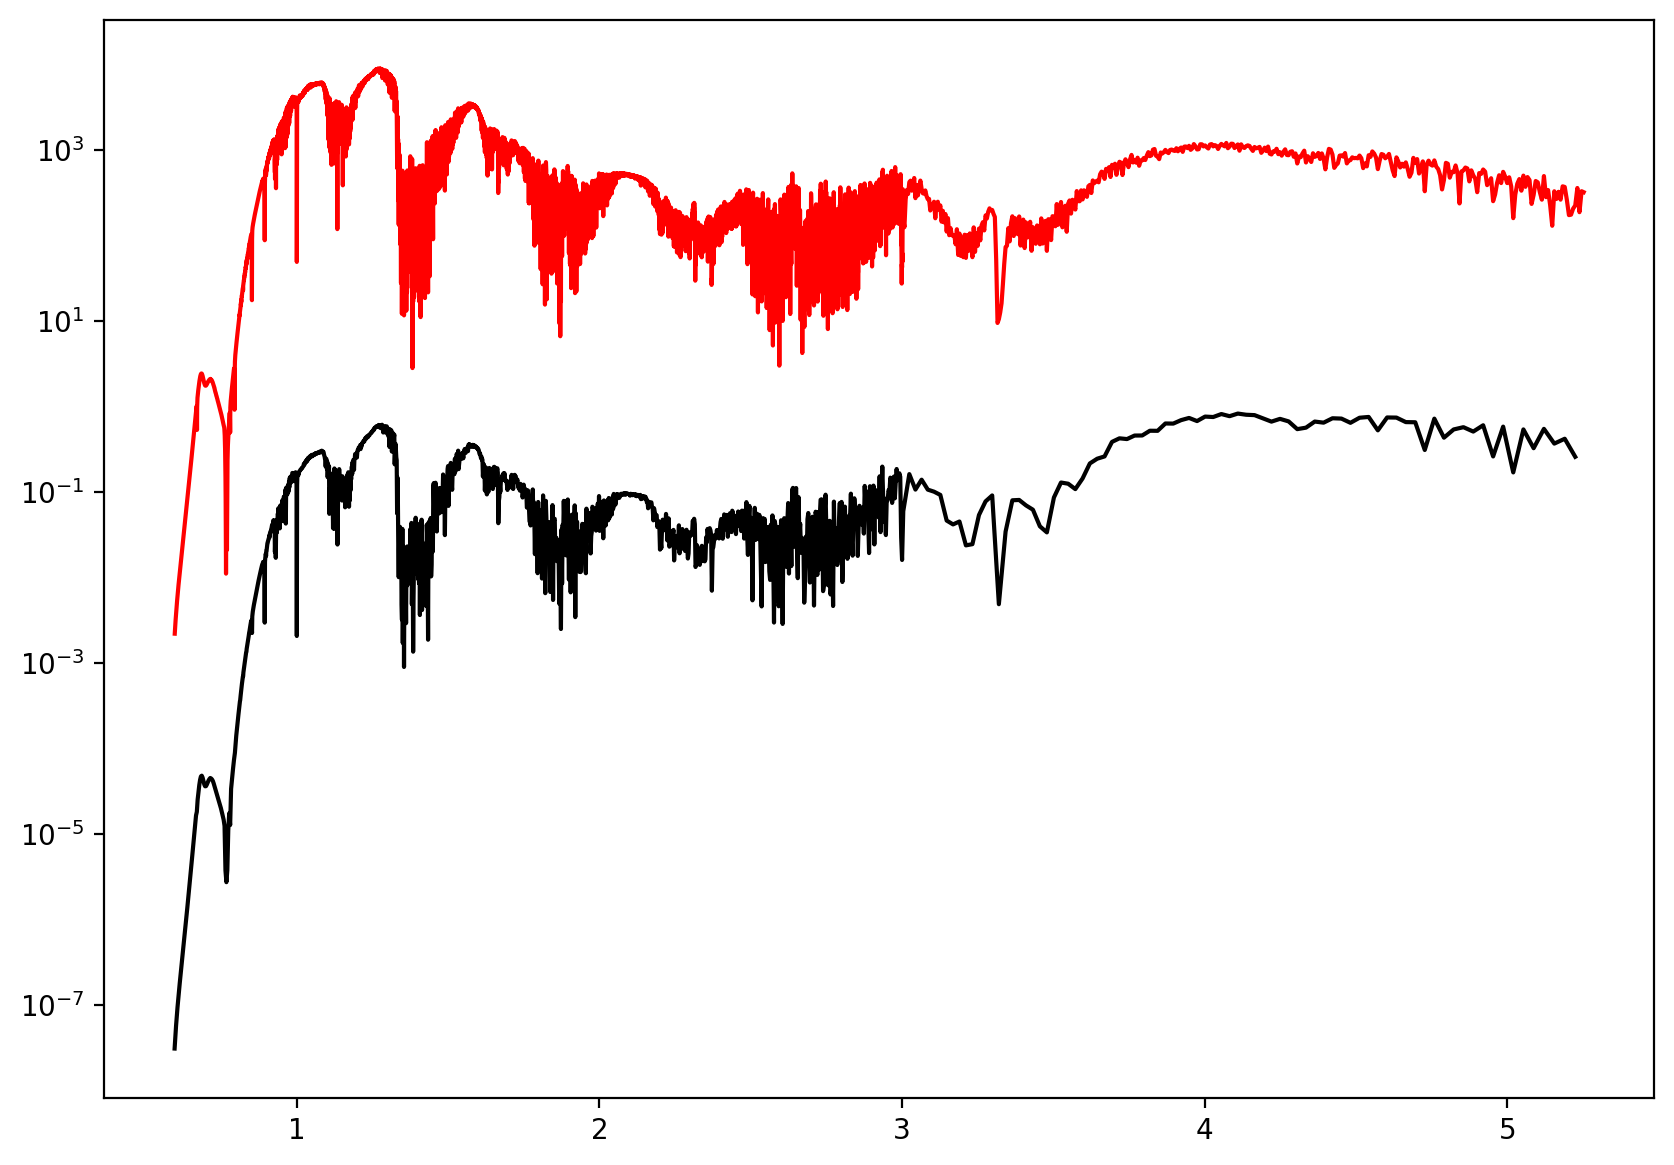

In [7]:
name, spec, model = read_model(data_files[0])

fig, ax = plt.subplots(figsize=(10, 7), dpi=200)

ax.plot(spec['x']/(1e4), spec['y'], color='black', alpha=1)
ax.plot(model[:,0]/(1e4), model[:,1], color='red', alpha=1)

ax.set_yscale('log')

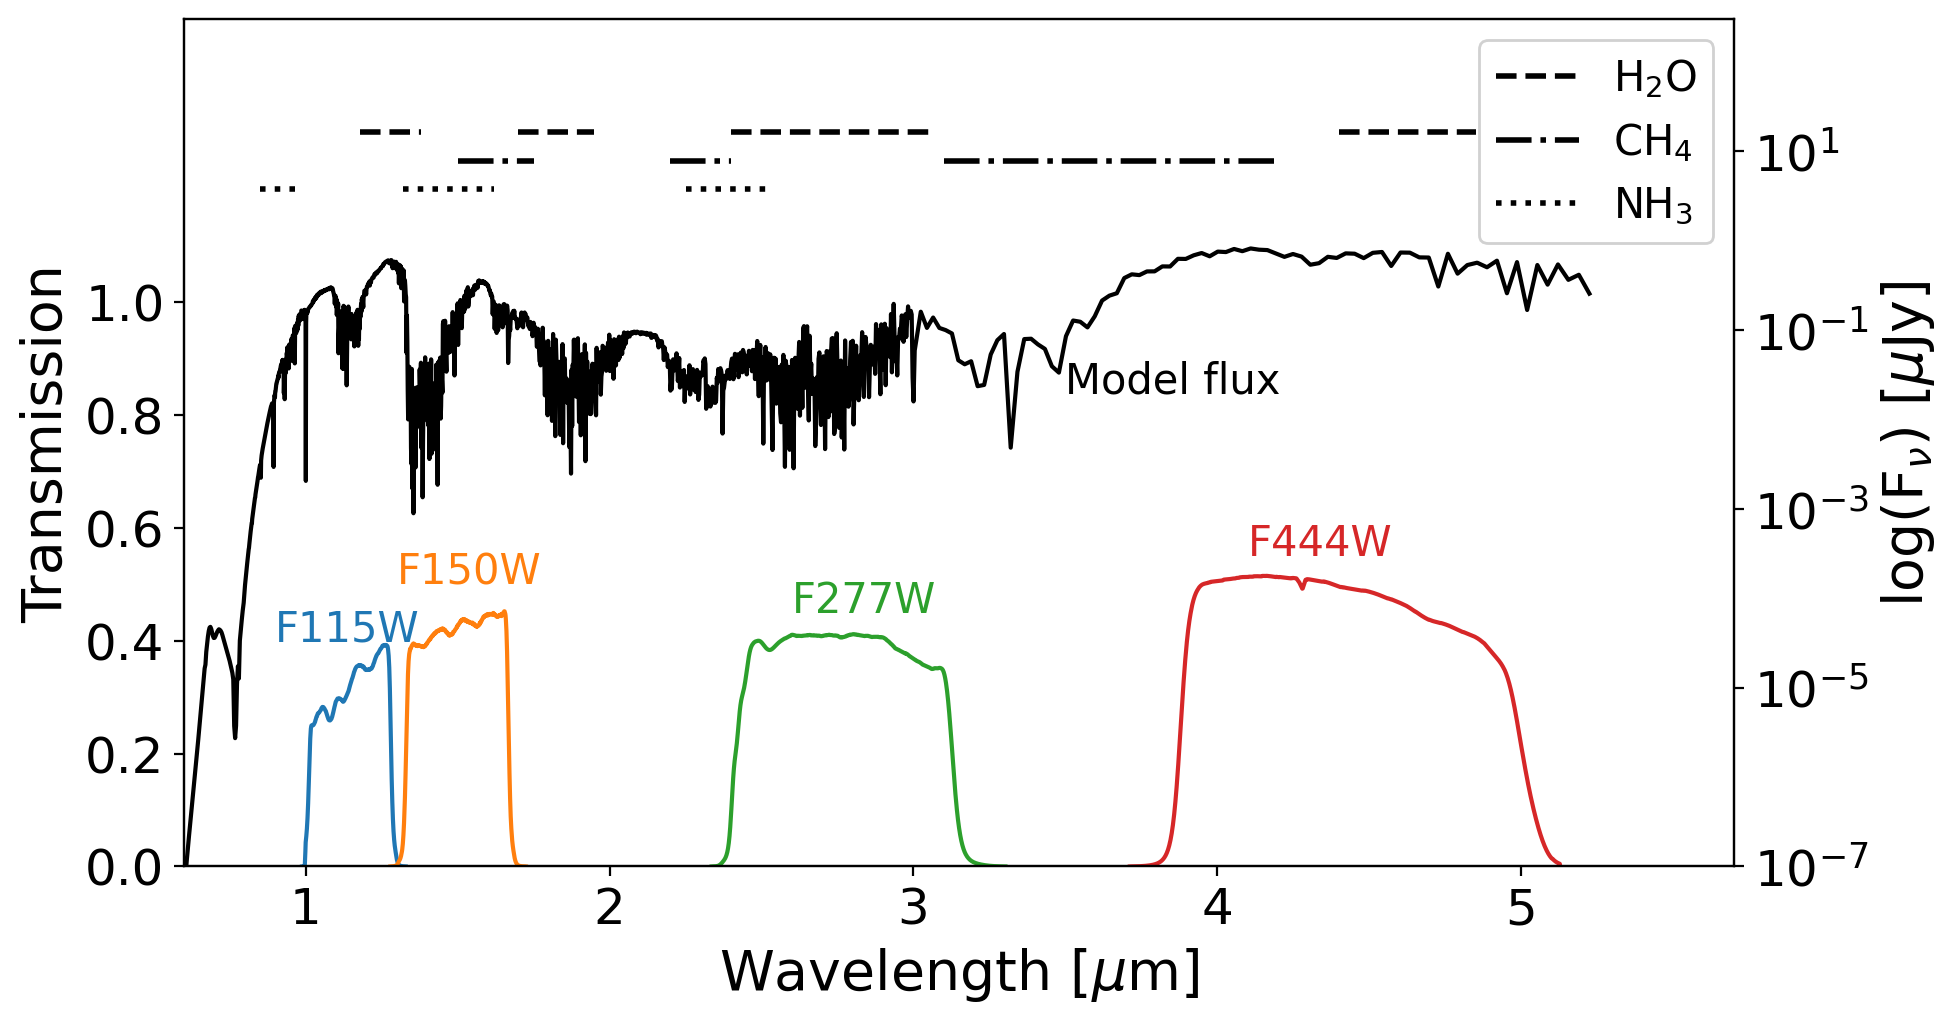

In [28]:
# spec = read_dat(data_name[0])
name, spec, model = read_model(data_files[0])

fig, ax = plt.subplots(figsize=(10, 5.5), dpi=200)

# plot filter transmission

for i in range(4):
    
    data = read_data_file(filter_name[i])
    ax.plot(data['x']/(1e4), data['y'], 
            # label=filter_name[i].split('/')[-1].split('.')[0].upper()
            )
    
hst = read_data_file(filter_name[4])

# ax.text(0.6, 0.25, 'F814W', fontsize=15, color='C4')
ax.text(0.9, 0.4, 'F115W', fontsize=15, color='C0')
ax.text(1.3, 0.5, 'F150W', fontsize=15, color='C1')
ax.text(2.6, 0.45, 'F277W', fontsize=15, color='C2')
ax.text(4.1, 0.55, 'F444W', fontsize=15, color='C3') 

# plot absorption lines
    
H2O = [[1.18, 1.38], [1.7, 1.95], [2.4, 3.05], [4.4, 4.85]]
CH4 = [[1.5, 1.75], [2.2, 2.4], [3.1, 4.2]]
NH3 = [[0.85, 0.97], [1.32, 1.62], [2.25, 2.52]]

for i in range(len(H2O)):
    if i == 0:
        ax.plot(H2O[i], [1.3, 1.3], color='k', lw=2, linestyle='--', label='H$_2$O')
    else:
        ax.plot(H2O[i], [1.3, 1.3], color='k', lw=2, linestyle='--')
for i in range(len(CH4)):
    if i == 0:
        ax.plot(CH4[i], [1.25, 1.25], color='k', lw=2, linestyle='-.', label='CH$_4$')
    else:
        ax.plot(CH4[i], [1.25, 1.25], color='k', lw=2, linestyle='-.')
for i in range(len(NH3)):
    if i == 0:
        ax.plot(NH3[i], [1.2, 1.2], color='k', lw=2, linestyle=':', label='NH$_3$')
    else:
        ax.plot(NH3[i], [1.2, 1.2], color='k', lw=2, linestyle=':')

ax.set_xlabel('Wavelength [$\mu$m]', fontsize=20)
ax.set_ylabel('Transmission', fontsize=20)

ax.set_xlim(0.6, 5.7)
# ax.set_xscale('log')

ax.set_ylim(0, 1.5)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(loc='upper right', framealpha=0.9, fontsize=15)

ax2 = ax.twinx()

ax2.plot(spec['x']/(1e4), spec['y'], color='black', alpha=1)
ax2.set_yscale('log')
ax2.set_ylabel('log(F$_{\\nu}$) [$\\mu$Jy]', fontsize=20)

ax2.text(3.5, 2e-2, 'Model flux ', fontsize=15, color='black')

ax2.set_ylim(1e-7, 3e2)
ax2.tick_params(axis='both', which='major', labelsize=18)
# ax2.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=15)

# plt.tight_layout()
plt.show()

### Model flux on cc

In [3]:
data_name1 = sorted(glob.glob('STAR/Sonora_Bobcat/spec_ds/*g*nc_m-0.5.dat'))
data_name2 = sorted(glob.glob('STAR/Sonora_Bobcat/spec_ds/*g*nc_m0.dat'))
data_name3 = sorted(glob.glob('STAR/Sonora_Bobcat/spec_ds/*g*nc_m+0.5.dat'))
filter_name = sorted(glob.glob('/home/yuan/LePhare/lephare_dev/filt/jwst/*'))

In [13]:
low_m = plot_Fmodel_cc(data_name1, filter_name)
nor_m = plot_Fmodel_cc(data_name2, filter_name)
high_m = plot_Fmodel_cc(data_name3, filter_name)
sources = pd.read_csv('/home/yuan/JWST/CentralDogma/2_Lust_/merged_5sig.csv')
candi = pd.read_csv('/home/yuan/JWST/CentralDogma/5_Wrath_/goodcandi.csv')

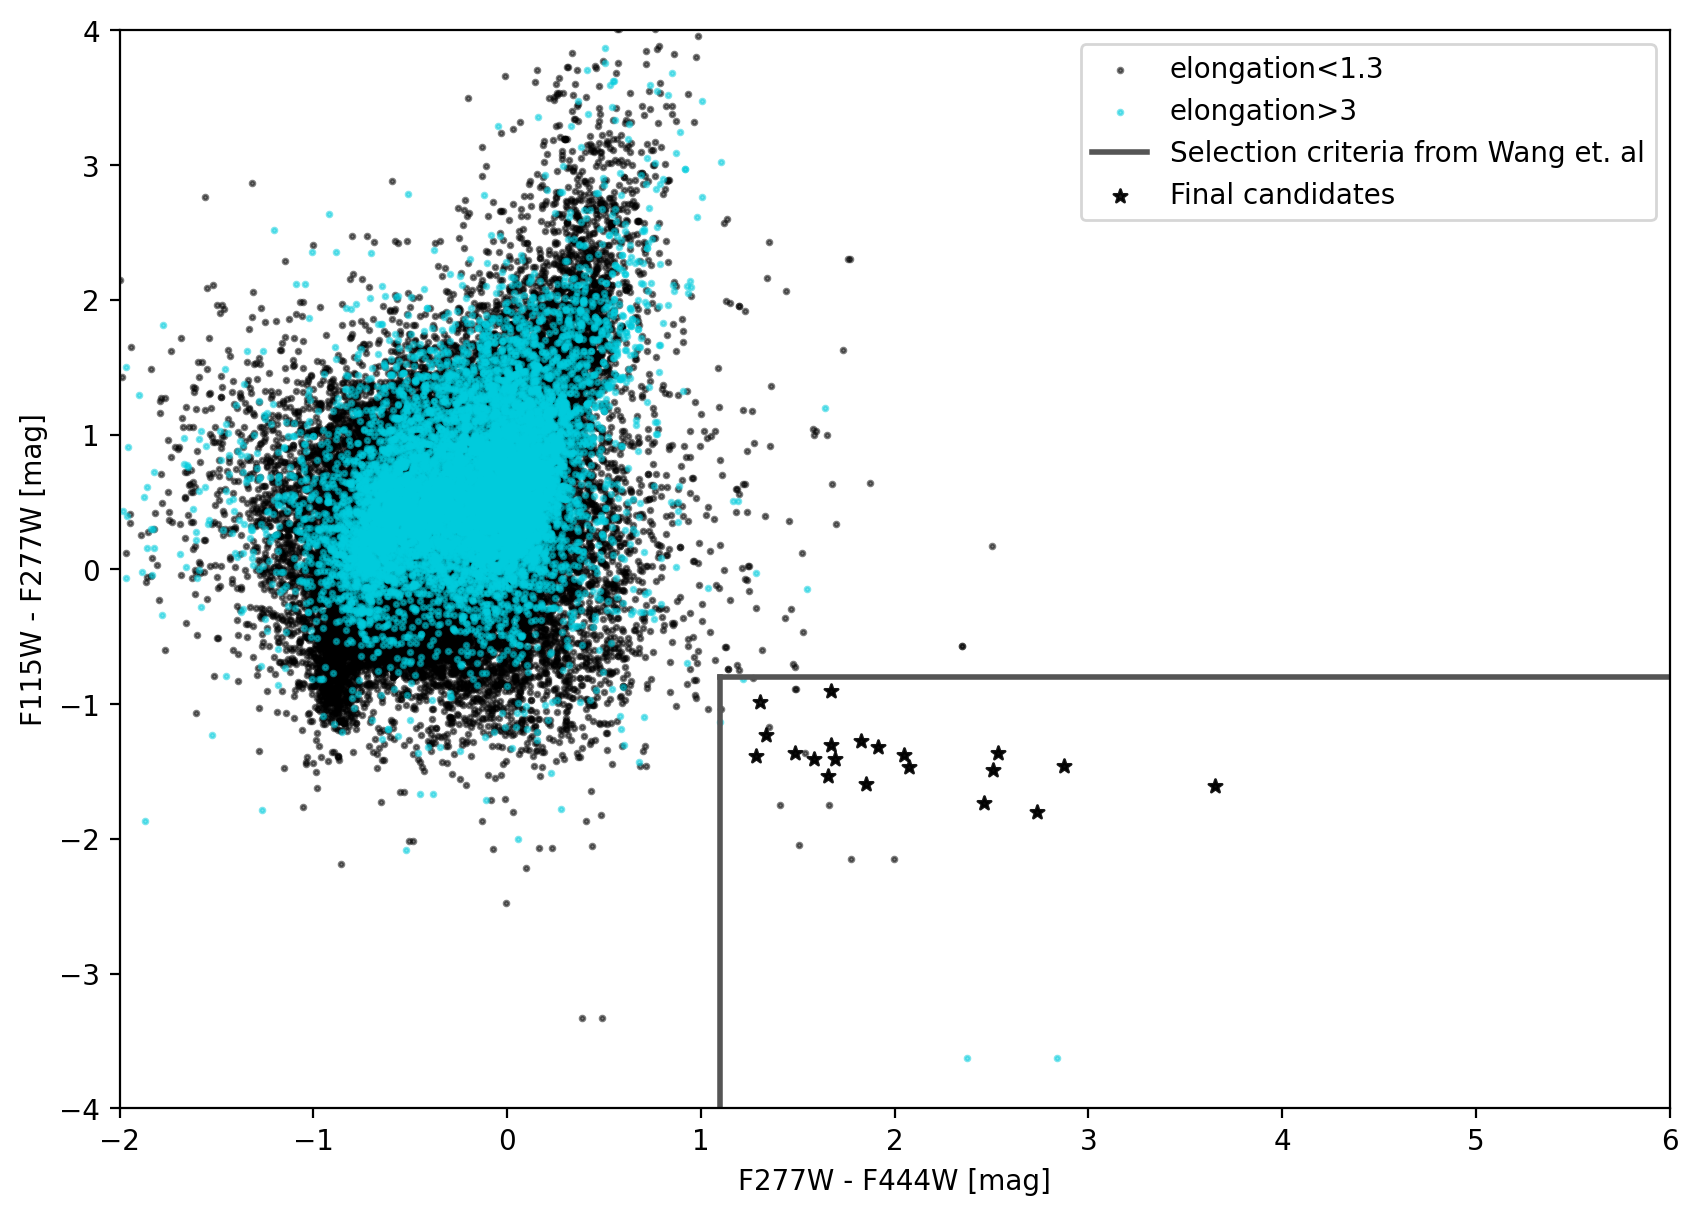

In [19]:
cc_para(sources, candi, 'ELONGATION_F115W', 3, 1.3)

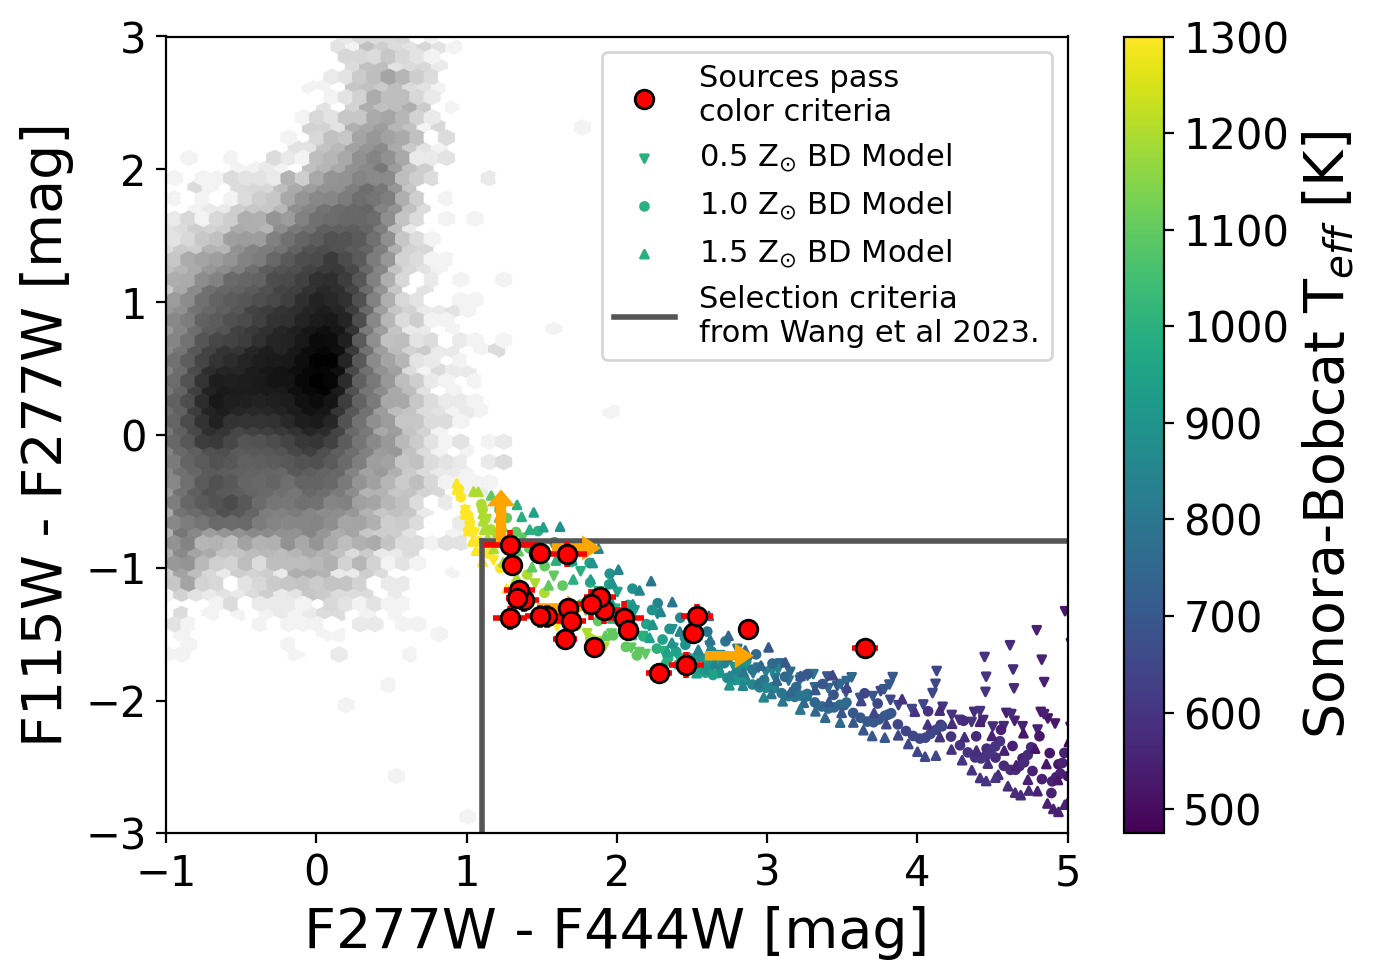

In [34]:
selected = ccplot(sources, candi, 'AUTO', save=True)

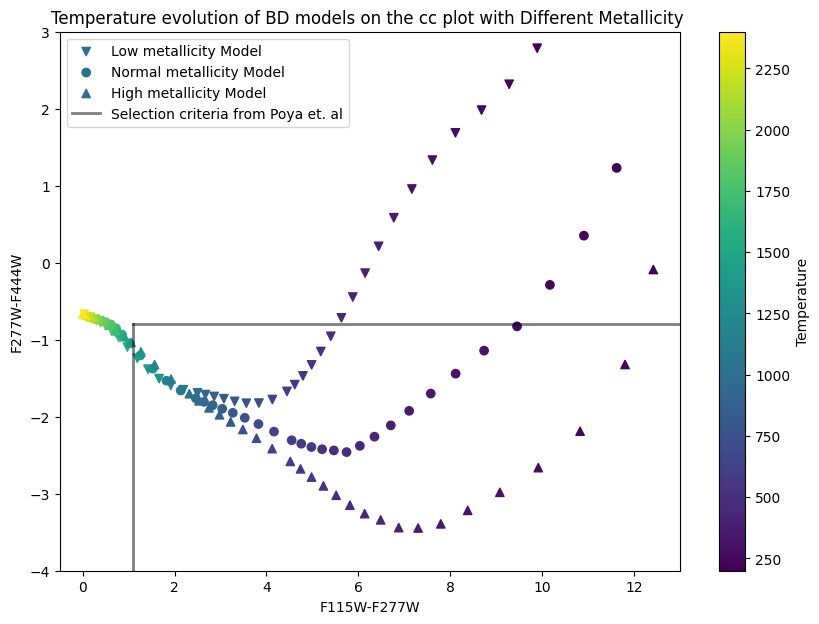

In [82]:
plt.figure(figsize=(10, 7))
        
# plot the model flux on the color-color plot and use T as colorbar
# Turn Temperature into color map


plt.scatter(low_m[2]-low_m[3], low_m[1]-low_m[2], c=low_m[0], 
            marker='v', cmap='viridis', label='Low metallicity Model')
plt.scatter(nor_m[2]-nor_m[3], nor_m[1]-nor_m[2], c=nor_m[0], 
            marker='o', cmap='viridis', label='Normal metallicity Model')
plt.scatter(high_m[2]-high_m[3], high_m[1]-high_m[2], c=high_m[0], 
            marker='^', cmap='viridis', label='High metallicity Model')

plt.colorbar(label='Temperature')

plt.plot([1.1, 1.1], [-4, -0.8], color='black', lw=2, alpha=0.5, label='Selection criteria from Poya et. al')
plt.plot([1.1, 15], [-0.8, -0.8], color='black', lw=2, alpha=0.5)

plt.xlim(-0.5, 13)
plt.ylim(-4, 3)

plt.xlabel('F115W-F277W')
plt.ylabel('F277W-F444W')
plt.title('Temperature evolution of BD models on the cc plot with Different Metallicity ')
plt.legend()
plt.show()

### Flux after filter

In [19]:
_filter = read_data_file(filter_name[0])

x, y = resample(read_dat(data_name[0]), _filter)

observed_mag(y, x, _filter)

25.26023331412144

In [35]:
data_name[11].split('/')[-1].split('t')[1].split('g')[0]

'200'

In [36]:
filter_name

['/home/yuan/LePhare/lephare_dev/filt/jwst/f115w.pb',
 '/home/yuan/LePhare/lephare_dev/filt/jwst/f150w.pb',
 '/home/yuan/LePhare/lephare_dev/filt/jwst/f277w.pb',
 '/home/yuan/LePhare/lephare_dev/filt/jwst/f444w.pb']

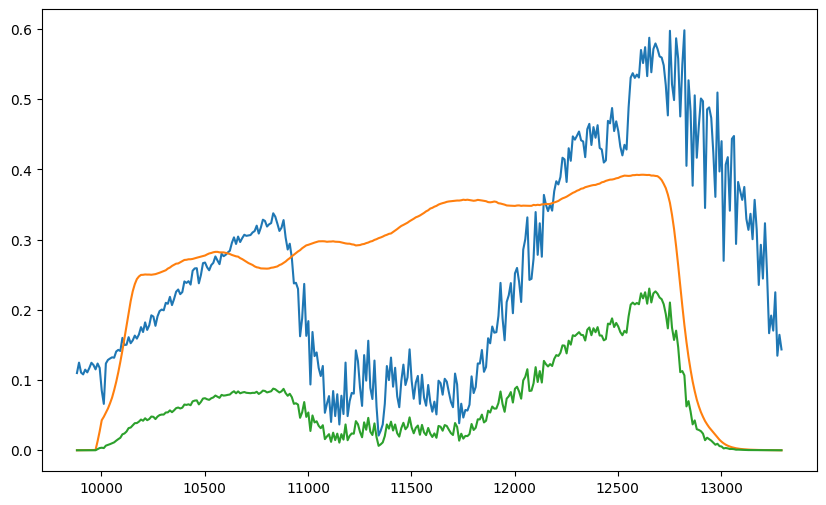

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# read data
_filter = read_data_file(filter_name[0])

x, y = resample(read_dat(data_name[0]), _filter)

ax.plot(x, y, label='resampled model')
ax.plot(_filter['x'], _filter['y'], label='filter')
ax.plot(_filter['x'], y*_filter['y'], label='resampled model * filter')